# <nobr>Micro$\mathbb{S}$plit</nobr>: Semantic Unmixing of Fluorescent Microscopy Data

In this notebook, we tackle the problem of joint splitting and unsupervised denoising, which has a use case in the field of fluorescence microscopy. From a technical perspective, given a noisy image $x$, the goal is to predict two images $c_1$ and $c_2$ such that $x = c_1 + c_2 + n$, where $n$ is the noise in $x$. In other words, we have a superimposed image $x$ and we want to predict the denoised estimates of the constituent images $c_1$ and $c_2$. It is important to note that the network is trained with noisy data and the denoising is done in a unsupervised manner.

For this, we will use [denoiSplit](https://arxiv.org/pdf/2403.11854.pdf), a recently developed approach for this task. In this notebook we train denoiSplit and later evaluate it on one validation frame. The overall schema for denoiSplit is shown below:
<!-- Insert a figure -->
<!-- ![Schema](imgs/teaser.png) -->
<img src="imgs/teaser.png" alt="drawing" width="800"/>

<div class="alert alert-danger">
Set your python kernel to <code>05_image_restoration</code>
</div>

In [1]:
from functools import partial
from pathlib import Path

import torch
import matplotlib.pyplot as plt
from careamics.lightning import VAEModule
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader

from microsplit_reproducibility.configs.factory import (
    create_algorithm_config,
    get_likelihood_config,
    get_loss_config,
    get_model_config,
    get_optimizer_config,
    get_training_config,
    get_lr_scheduler_config,
)
from microsplit_reproducibility.utils.callbacks import get_callbacks
from microsplit_reproducibility.utils.io import load_checkpoint_path
from microsplit_reproducibility.datasets import create_train_val_datasets
from microsplit_reproducibility.utils.utils import plot_input_patches
from microsplit_reproducibility.configs.parameters.custom_dataset_2D import (
    get_microsplit_parameters
)
from microsplit_reproducibility.configs.data.custom_dataset_2D import get_data_configs

from utils import get_train_val_data

%matplotlib inline

In [2]:
assert torch.cuda.is_available()

Below, we will train a <nobr>Micro$\mathbb{S}$plit</nobr> network for unmixing two or more superimposed channels for a custom 2D dataset you provide. 

You should organize you dataset as follows:
- Create a `data` directory
- Create subdirectories `channel_1`, `channel_2`, etc, containing the channels you would like to unmix
- Make sure that the images have the same spatial size and each image has only 1 channel

Your data directory should look like this:
```
you_data_path/
└── data
    ├── channel_1
    │   ├── image1.tiff
    │   ├── image2.tiff
    │   └── image3.tiff
    └── channel_2
    │   ├── image1.tiff
    │   ├── image2.tiff
    │   └── image3.tiff
    └── channel_n
    │   ├── image1.tiff
    │   ├── image2.tiff
    │   └── image3.tiff
```

The mixed image used for splitting will be obtained artificially by a convex combination of the target channels.

Let's begin!

# **Exercise 1**: Training MicroSplit
Training is done in a supervised way. For every input patch, we have the two corresponding target patches using which we train our MicroSplit. 
Besides the primary input patch, we also feed LC inputs to MicroSplit. We introduced LC inputs in [μSplit: efficient image decomposition for microscopy data](https://openaccess.thecvf.com/content/ICCV2023/papers/Ashesh_uSplit_Image_Decomposition_for_Fluorescence_Microscopy_ICCV_2023_paper.pdf), which enabled the network to understand the global spatial context around the input patch.

To enable unsupervised denoising, we integrated the KL loss formulation and Noise models from our previous work [denoiSplit: a method for joint microscopy image splitting and unsupervised denoising](https://eccv.ecva.net/virtual/2024/poster/2538). 

The loss function for MicroSplit is a weighted average of denoiSplit loss and μSplit loss. For both denoiSplit and μSplit, their loss expression have two terms: KL divergence loss and likelihood loss. For more details, please refer to the respective papers.

### Setup the path to the noise models
This is the path to the noise models that you trained in the notebook **00_noisemodels.ipynb**

In [3]:
NM_PATH = Path("./noise_models/")

## 1.1. Data Preparation

Since the channel unmixing capabilities of <nobr>Micro$\mathbb{S}$plit</nobr> are trained in a supervised way, we must later feed *(i)* input images that contain both selected structures, and *(ii)* two seperate channels that show these two structures separately. As previosuly mentioned, the mixed input image is obtained synthetically by overlapping the other two channels.

In this exercise, we will train a <nobr>Micro$\mathbb{S}$plit</nobr> network for unmixing superimposed channels from a dataset imaged at the National Facility for Light Imaging at Human Technopole.

This dataset contains four labeled structures: 
1. Cell Nucleui,
1. Microtubules,
1. Nuclear Membrane,
1. Centromeres/Kinetocores.

Additionally, this dataset offers acquisitions taken with different exposure times **(2, 20, 500 ms)**. Hence, the data is available at various [signal-to-noise ratios](https://en.wikipedia.org/wiki/Signal-to-noise_ratio#:~:text=Signal%2Dto%2Dnoise%20ratio%20(,power%2C%20often%20expressed%20in%20decibels.)) (SNR). Shorter exposure times entails the collection of fewer photons, leading to higher *Poisson shot noise* and, therefore, a lower SNR.

<div class="alert alert-info"><h4><b>Task 1.1.</b></h4>

In the following, you will be prompted to select:
1. The labeled structures to unmix;
2. The exposure time (and, thus, the SNR) of the input superimposed images.

Observe that:
- The more structures to unmix you pick, the more difficult the task becomes. Therefore, we suggest to start with an easier 2-structures unmixing and then try out 3 and 4 structures unmixing later on.
- The lower the SNR of the data you will choose to train <nobr>Micro$\mathbb{S}$plit</nobr> with, the more important will the unsupervised denoising feature of <nobr>Micro$\mathbb{S}$plit</nobr> become.

</div>

A few notes:
- MicroSplit is trained on `(64, 64)` patches mainly for GPU memory contraints. Indeed, to train on full images we would need to reduce the batch size, which, unfortunately, has shown to hinder the model performance in our experiments.
- ...

In [20]:
# pick structures and exposure time
STRUCTURES = ["Nuclei", "Microtubules", "Centromeres"] # choose among "Nuclei", "Microtubules", "NucMembranes", "Centromeres"
EXPOSURE_TIME = 500 # in ms, choose among 2, 20, 500 ms

assert EXPOSURE_TIME in [2, 20, 500], "Exposure time must be one of [2, 20, 500] ms"
assert all([
    s in ["Nuclei", "Microtubules", "NucMembranes", "Centromeres"] for s in STRUCTURES
]), "Invalid structure selected. Choose among 'Nuclei', 'Microtubules', 'NucMembranes', 'Centromeres'."

Custom functions for loading data

In [21]:
load_data_func = partial(get_train_val_data, structures=STRUCTURES)

In [22]:
datapath = Path(f"/group/jug/federico/data/MBL_course/{EXPOSURE_TIME}ms") # FIXME

In [23]:
train_data_config, val_data_config, test_data_config = get_data_configs(
    image_size=(64, 64),
    num_channels=len(STRUCTURES),
)

In [24]:
# create the dataset
train_dset, val_dset, _, data_stats = create_train_val_datasets(
    datapath=datapath,
    train_config=train_data_config,
    val_config=val_data_config,
    test_config=val_data_config,
    load_data_func=load_data_func,
)


Padding is not used with this alignement style

Padding is not used with this alignement style

Padding is not used with this alignement style


In [25]:
train_dloader = DataLoader(
    train_dset,
    batch_size=32,
    num_workers=3,
    shuffle=True,
)
val_dloader = DataLoader(
    val_dset,
    batch_size=32,
    num_workers=3,
    shuffle=False,
)

**Show some training data for a final check!**

***Tip:*** we show you a few samples of the prepared training data. In case you don't like what you see, execute the cell again and other randomly chosen patches will be shown!

[192230, 160735, 96332]

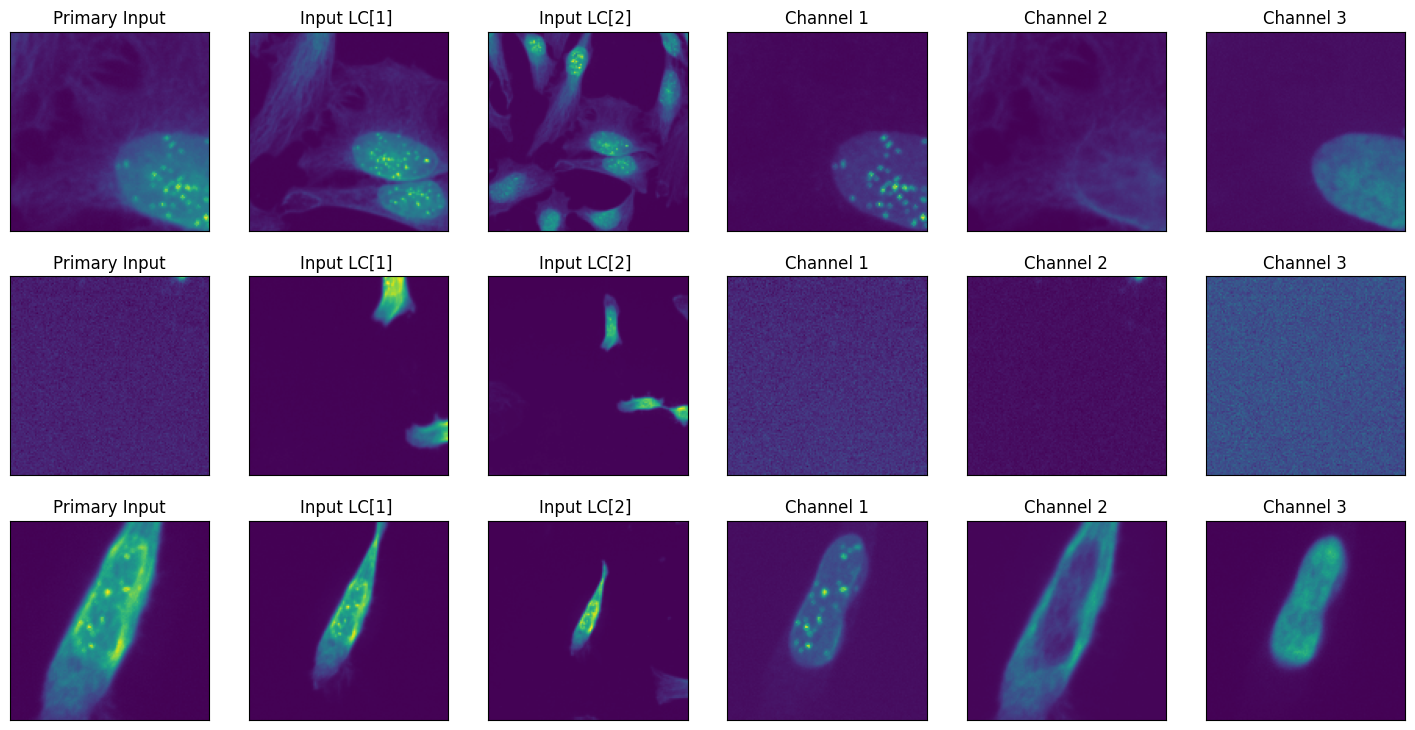

In [34]:
plot_input_patches(dataset=train_dset, num_channels=len(STRUCTURES), num_samples=3, patch_size=128)

<div class="alert alert-warning"><h4><b>Question 1.1.</b></h4>

Below are 2 examples of superimposed labeled structures with the correspondent ground truths. 
1. Which one you think it's harder to unmix? Why?
2. What are, in your opinion, features of the input data that would make unmixing more difficult? 

*Answers*
1. (b), because it shows more morphologically similar structures. MicroSplit is a content-aware method, i.e., it extracts semantic information regarding morphology, shape, brightness, etc., from the input data. Since structurally similar signal share many semantic features, the unmixing task becomes more challenging.
2. Semantic similarity between labeled structures, difference in brightness/intensity between labeled structures, colocalization, ...
</div>

<div class="alert alert-success"><h2><b>Checkpoint 1: Data Preparation</b></h2>
</div>

<hr style="height:2px;">

# **Step 1.2:** Prepare <nobr>Micro$\mathbb{S}$plit</nobr> Training
Next, we create all the configs for the upcoming network training run. These lines are not very intuitive and if you don't intend to dive really deep into CAREamics and the internals of <nobr>Micro$\mathbb{S}$plit</nobr>, you might just execute these cells and move on.

In [ ]:
NUM_CHANNELS = 2
"""The number of channels considered for the splitting task."""
BATCH_SIZE = 32
"""The batch size for training."""
PATCH_SIZE = (64, 64)
"""The size of the patches fed to the network for training in (Y, X)."""
EPOCHS = 10
"""The number of epochs to train the network."""

In [ ]:
# setting up MicroSplit parametrization
experiment_params = get_microsplit_parameters(
    algorithm="denoisplit",
    img_size=PATCH_SIZE,
    batch_size=BATCH_SIZE,
    num_epochs=EPOCHS,
    multiscale_count=3,
    noise_model_path=NM_PATH,
    target_channels=NUM_CHANNELS,
)

In [ ]:
# making our data_stas known to the experiment we prepare
experiment_params["data_stats"] = data_stats

# setting up training losses and model config (using default parameters)
loss_config = get_loss_config(**experiment_params)
model_config = get_model_config(**experiment_params)
gaussian_lik_config, noise_model_config, nm_lik_config = get_likelihood_config(
    **experiment_params
)
training_config = get_training_config(**experiment_params)

# setting up learning rate scheduler and optimizer (using default parameters)
lr_scheduler_config = get_lr_scheduler_config(**experiment_params)
optimizer_config = get_optimizer_config(**experiment_params)

# finally, assemble the full set of experiment configurations...
experiment_config = create_algorithm_config(
    algorithm=experiment_params["algorithm"],
    loss_config=loss_config,
    model_config=model_config,
    gaussian_lik_config=gaussian_lik_config,
    nm_config=noise_model_config,
    nm_lik_config=nm_lik_config,
    lr_scheduler_config=lr_scheduler_config,
    optimizer_config=optimizer_config,
)

In [ ]:
model = VAEModule(algorithm_config=experiment_config)

### *Load checkpoint (optional and for you to implement)*

<div class="alert alert-block alert-success">
<b>Note:</b> If you would like to continue a previous training run or finetune a compatible pre-trained model, here would be a good place. You will need to figure out how to implement this for your use-case, but to give you a head-start, we left three potentially useful lines of code below.
</div>

In [ ]:
# from microsplit_reproducibility.notebook_utils.HT_LIF24 import load_pretrained_model
# ckpt_path = load_checkpoint_path(f"./pretrained_checkpoints/{EXPOSURE_DURATION}/", best=True)
# load_pretrained_model(model, ckpt_path)

# **Step 1.3:** Train the prepared model!
***Note:*** if this takes too long, there were to places above where we gave you options to *(i)* reduce the amount of training data, and *(ii)* chose to train for fewer epochs. Revisit your choices if you want to!

***Note:*** Depending on the amount of GPU memory you have available, you might want to adjust the batch size. The default is 32, but you can reduce it to 16 if you run out of memory by changing the <i> batch_size </i> parameter in <i> get_microsplit_parameters </i> above.


In [ ]:
# create the Trainer
trainer = Trainer(
    max_epochs=training_config.num_epochs,
    accelerator="gpu",
    enable_progress_bar=True,
    callbacks=get_callbacks("./checkpoints/"),
    precision=training_config.precision,
    gradient_clip_val=training_config.gradient_clip_val,
    gradient_clip_algorithm=training_config.gradient_clip_algorithm,
)

In [ ]:
# start the training
trainer.fit(
    model=model,
    train_dataloaders=train_dloader,
    val_dataloaders=val_dloader,
)

# **Step 1.4:** Predict and visualize results for validation data...

***Note*** Parameter `mmse_count` is responsible for how many samples are generated for each patch. The default value is 1, but in this case you might see stitching artifacts because each patch will be slightly different. You can increase this value to 10 to get a smoother image

In [ ]:
from microsplit_reproducibility.notebook_utils.custom_dataset_2D import (
    get_unnormalized_predictions,
    get_target,
    get_input,
)

stitched_predictions, _, _ = get_unnormalized_predictions(
    model, val_dset, mmse_count=experiment_params['mmse_count'], num_workers=0, batch_size=8
)
tar = get_target(val_dset)

# get input as sum of the two channels
inp = get_input(val_dset).sum(-1)

## Overview: visualize predictions on validation data...

In [ ]:
_, ax = plt.subplots(2, 2, figsize=(20, 20))
ax[0, 0].imshow(tar[0, ..., 0], cmap="gray")
ax[0, 0].set_title("Input ch1")
ax[0, 1].imshow(tar[0, ..., 1], cmap="gray")
ax[0, 1].set_title("Input ch2")
ax[1, 0].imshow(stitched_predictions[0, ..., 0], cmap="gray")
ax[1, 0].set_title("Prediction ch1")
ax[1, 1].imshow(stitched_predictions[0, ..., 1], cmap="gray")
ax[1, 1].set_title("Prediction ch2")

In [ ]:
from microsplit_reproducibility.notebook_utils.custom_dataset_2D import full_frame_evaluation

frame_idx = 0
assert frame_idx < len(stitched_predictions), f"Frame index {frame_idx} out of bounds"
full_frame_evaluation(stitched_predictions[frame_idx], tar[frame_idx], inp[frame_idx])

## Detailed view on some (foreground) locations...
Below, we show few random foreground locations and the corresponding <nobr>Micro$\mathbb{S}$plit</nobr> predictions.

As before, also here you can execute the cell multiple times and different randomly chosen locations will be plotted.

In [ ]:
import numpy as np
from microsplit_reproducibility.utils.utils import clean_ax
from microsplit_reproducibility.notebook_utils.custom_dataset_2D import (
    pick_random_patches_with_content,
)
import matplotlib.pyplot as plt

img_sz = 128
rand_locations = pick_random_patches_with_content(tar, 128)
h_start = rand_locations[
    2, 0
]  # np.random.randint(stitched_predictions.shape[1] - img_sz)
w_start = rand_locations[
    2, 1
]  # np.random.randint(stitched_predictions.shape[2] - img_sz)

ncols = 4 + 1
nrows = min(len(rand_locations), 5)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 3, nrows * 3))

for i, (h_start, w_start) in enumerate(rand_locations[:nrows]):
    ax[i, 0].imshow(inp[0, h_start : h_start + img_sz, w_start : w_start + img_sz])
    for j in range(ncols // 2):
        vmin = stitched_predictions[
            0, h_start : h_start + img_sz, w_start : w_start + img_sz, j
        ].min()
        vmax = stitched_predictions[
            0, h_start : h_start + img_sz, w_start : w_start + img_sz, j
        ].max()
        ax[i, 2 * j + 1].imshow(
            tar[0, h_start : h_start + img_sz, w_start : w_start + img_sz, j],
            vmin=vmin,
            vmax=vmax,
        )
        ax[i, 2 * j + 2].imshow(
            stitched_predictions[
                0, h_start : h_start + img_sz, w_start : w_start + img_sz, j
            ],
            vmin=vmin,
            vmax=vmax,
        )

ax[0, 0].set_title("Primary Input")
for i in range(2):
    ax[0, 2 * i + 1].set_title(f"Target Channel {i+1}")
    ax[0, 2 * i + 2].set_title(f"Predicted Channel {i+1}")

# reduce the spacing between the subplots
plt.subplots_adjust(wspace=0.03, hspace=0.03)
clean_ax(ax)

## *Optional:* manual inspection of the predictions
<div class="alert alert-block alert-info">
<b> Task:</b> Set <i>y_start</i>, <i>x_start</i>, and <i>crop_size</i> to inspect the predictions at a  location of your choice.
</div>

In [ ]:
import numpy as np

y_start = 600  # np.random.randint(stitched_predictions.shape[1] - crop_size)
x_start = 1150  # np.random.randint(stitched_predictions.shape[2] - crop_size)
crop_size = 128

ncols = 3
nrows = 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))
ax[0, 0].imshow(inp[0, y_start : y_start + crop_size, x_start : x_start + crop_size])
for i in range(ncols - 1):
    vmin = stitched_predictions[
        0, y_start : y_start + crop_size, x_start : x_start + crop_size, i
    ].min()
    vmax = stitched_predictions[
        0, y_start : y_start + crop_size, x_start : x_start + crop_size, i
    ].max()
    ax[0, i + 1].imshow(
        tar[0, y_start : y_start + crop_size, x_start : x_start + crop_size, i],
        vmin=vmin,
        vmax=vmax,
    )
    ax[1, i + 1].imshow(
        stitched_predictions[
            0, y_start : y_start + crop_size, x_start : x_start + crop_size, i
        ],
        vmin=vmin,
        vmax=vmax,
    )

# disable the axis for ax[1,0]
ax[1, 0].axis("off")
ax[0, 0].set_title("Input")
ax[0, 1].set_title("Channel 1")
ax[0, 2].set_title("Channel 2")
# set y labels on the right for ax[0,2]
ax[0, 2].yaxis.set_label_position("right")
ax[0, 2].set_ylabel("Target")

ax[1, 2].yaxis.set_label_position("right")
ax[1, 2].set_ylabel("Predicted")

print("Here the crop you selected:")

# ***Optional Step 1.4:*** Posterior Sampling
As we mentioned before, <nobr>Micro$\mathbb{S}$plit</nobr> backbone is based on a Hierarchical Variational Autoencoder. For this reason, given an input patch, it can generate multiple outputs by sampling multiple latent vectors in the latent space. In more mathematical terms, <nobr>Micro$\mathbb{S}$plit</nobr> is learning a full posterior of possible solutions.

This is a quite powerful feature!!! Indeed, this allows us to visually judge and have a rough estimate of the (data) uncertainty in the model's predictions.

Below, we show two posterior samples and how much they differ for a few random foreground locations. Re-run the cell to see different randomly choosen locations and corresponding posterior samples.

In [ ]:
from microsplit_reproducibility.notebook_utils.custom_dataset_2D import show_sampling

imgsz = 3
ncols = 6
examplecount = 3
_, ax = plt.subplots(
    figsize=(imgsz * ncols, imgsz * 2 * examplecount),
    ncols=ncols,
    nrows=2 * examplecount,
)

show_sampling(val_dset, model, ax=ax[:2])
show_sampling(val_dset, model, ax=ax[2:4])
show_sampling(val_dset, model, ax=ax[4:6])
plt.tight_layout()

### You are done here! 👍 Congratulations! 🎉